In [3]:
import networkx as nx
import cluster_query_tool
lfr = nx.community.community_generators.LFR_benchmark_graph
from subprocess import check_output
import networkx as nx
from collections import defaultdict
import numpy as np
from collections import defaultdict
from cluster_query_tool.louvain_consensus import mu_ivector, mu_iscore, mu_ivector
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import os

Testing the method on the standard LFR benchmark.
The mixing parameter (which determines the number of edges between communities) is set to 0.68 which is as high as I can get it without the generator breaking.

In [4]:
from cigram import lfr_benchmark_graph

# Edge between communities parameter (mu)
# saved = 0.23, 0.35, 0.6, 0.68

params = dict(
    mu=0.8,
    n=1000,
    average_degree=15,
    max_degree=300,
    minc_size=1,
    maxc_size=100,
    seed=1337
)

graph, comms = lfr_benchmark_graph(**params)



06/11/2018 12:02:24 PM Calling LFR Code
06/11/2018 12:02:24 PM Setting random seed
06/11/2018 12:02:24 PM Generating benchmark
06/11/2018 12:02:24 PM Benchmark starting 
06/11/2018 12:02:24 PM community size range automatically set
06/11/2018 12:02:24 PM Node degrees 
06/11/2018 12:02:24 PM Node degrees internal
06/11/2018 12:02:24 PM IDEG _MEMBERSHIP
06/11/2018 12:02:24 PM Calling powerlaw to generate community distribution
06/11/2018 12:02:24 PM Setting internal degree
06/11/2018 12:02:24 PM Setting Memberships
06/11/2018 12:02:24 PM Memberships assigned
06/11/2018 12:02:24 PM Return internal degree
06/11/2018 12:02:24 PM building communities... 
06/11/2018 12:02:24 PM connecting communities... 
06/11/2018 12:02:24 PM Benchmark complete
06/11/2018 12:02:24 PM Building network py objects
06/11/2018 12:02:24 PM Building return list 
06/11/2018 12:02:24 PM Exit LFR Code


## Generate the clustering space
Here we generate the "index" - or set of clusterings of the network.

By default the coverage parameter is set to medium. Full coverage would be to find every locally minimum soultion in the network.

In [11]:
# Generate an index
from cluster_query_tool import indexer

print(graph.name)
index = indexer.get_index(graph, space_sample_size=500)

lfr_binary_1000-15.0-2.0-1.0-0.8--214741-300-0-0-1-100-1337-False-False-False


Ignore this section, I was just using it for a test. I switched to the sci-kit learn AUC/ROC calculation because I thought there was an issue with my code....

In [12]:
from scipy.special import binom
import itertools

def unique_sampler(node_set, sample_size, max_samples=120):
    sample_sets = set()
    
    # maximum number of samples
    sspace = binom(len(node_set), sample_size)
    if sspace > max_samples:
        
        if sspace > max_samples * 2:
            # problem with this loop is when max_samples is close to n choose k
            while len(sample_sets) < max_samples:
                samp = tuple(sorted(np.random.choice(node_set, sample_size, replace=False)))
                sample_sets.add(samp)
        else:
            # Generate max_samples, unique random numbers sampling without replacement from possible combinations
            # Faster than above loop in case where n choose k is close to max_samples
            sp = np.random.choice(range(int(binom(len(node_set), sample_size))), max_samples, replace=False)
            poss = list(itertools.combinations(node_set, sample_size))
            for s in  sp:
                sample_sets.add(poss[s])
            
    else:
        sample_sets = set(itertools.combinations(node_set, sample_size))
    
    return sample_sets
    

The results:

Here we plot a ROC curve for randomly sampled sets of lables from the communities.
Interpret the mu_i score as a classifier from an ensemble of clusters.

If the mixing parameter is below about 0.5 the AUC score is essentially 1.0...

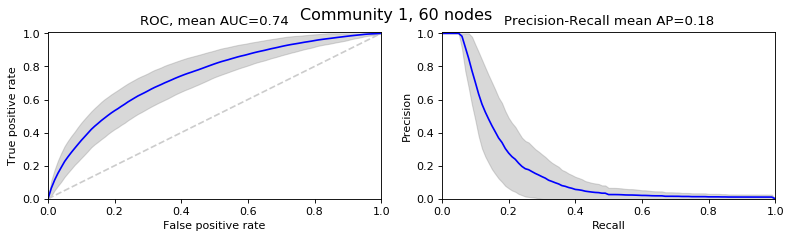

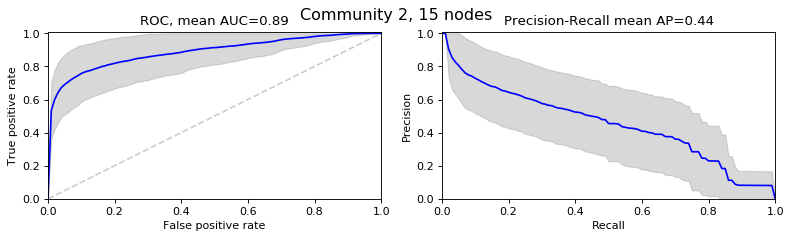

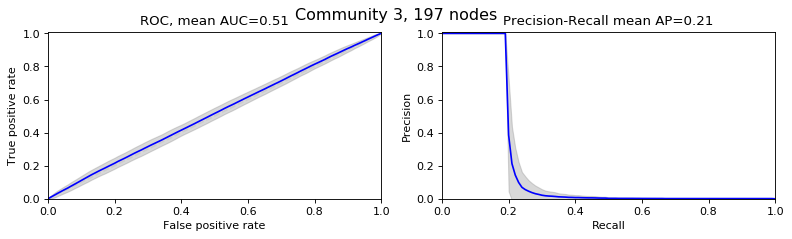

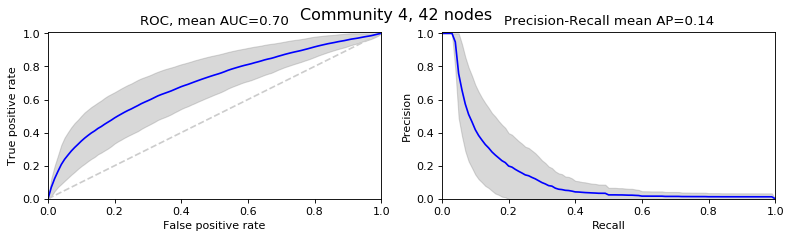

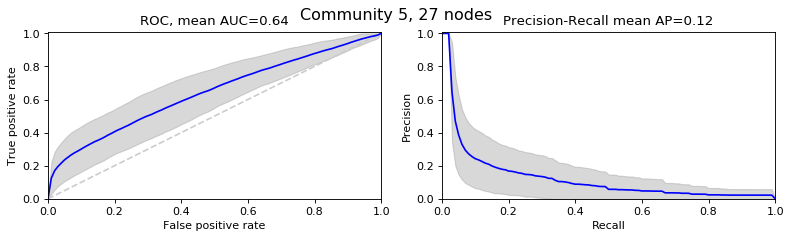

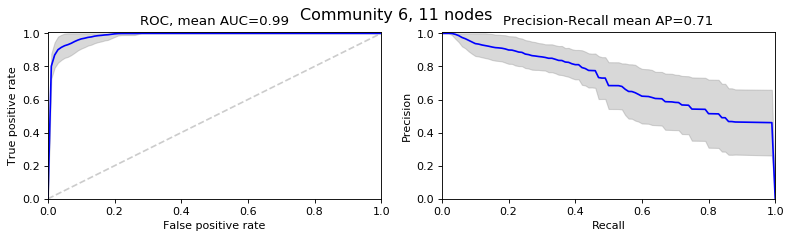

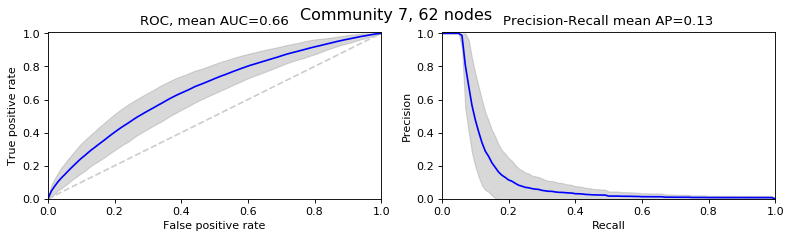

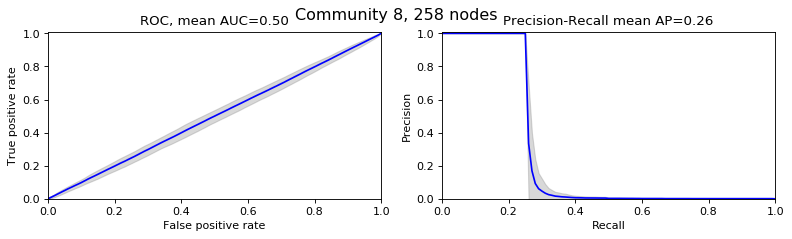

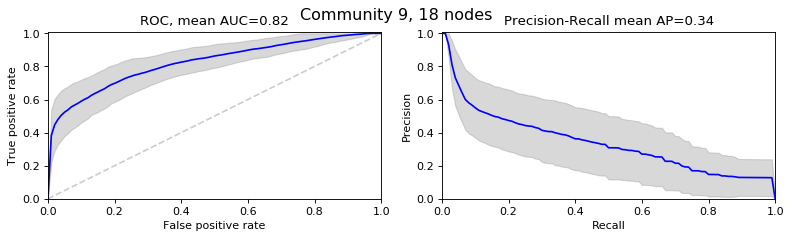

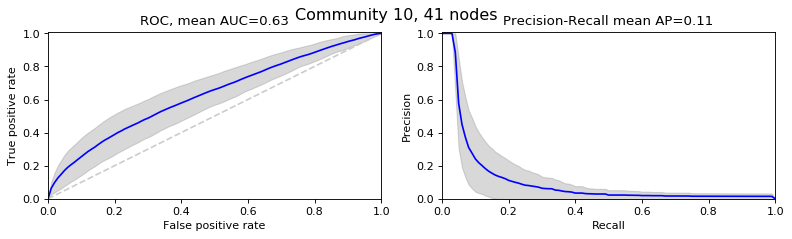

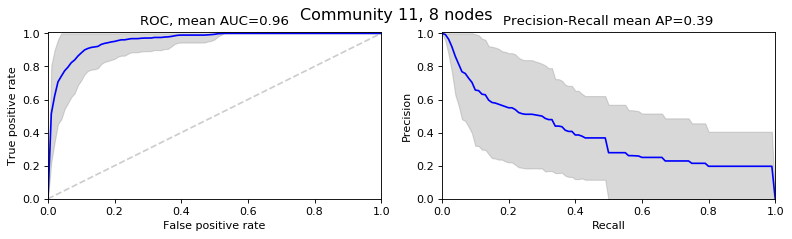

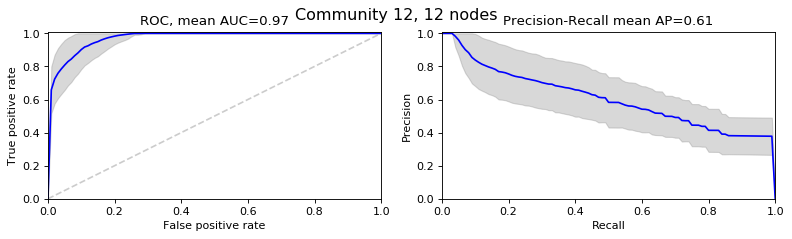

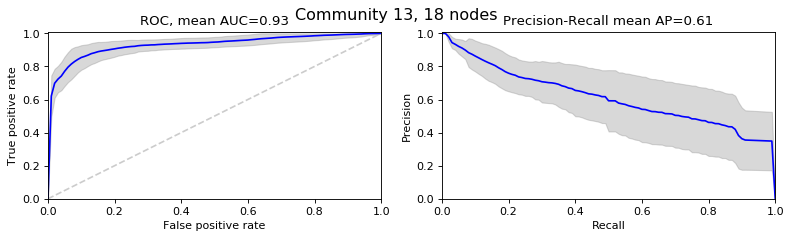

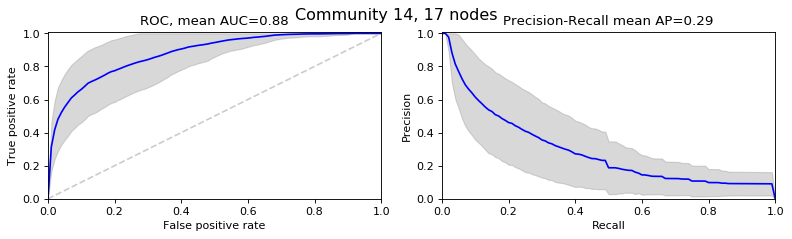

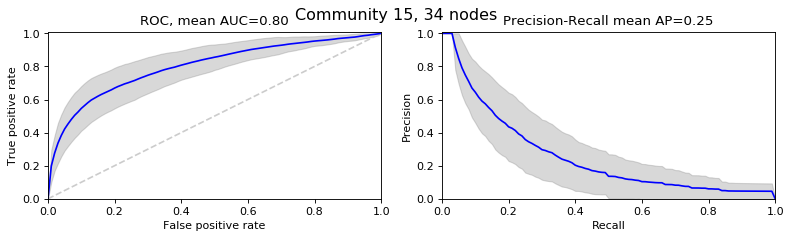

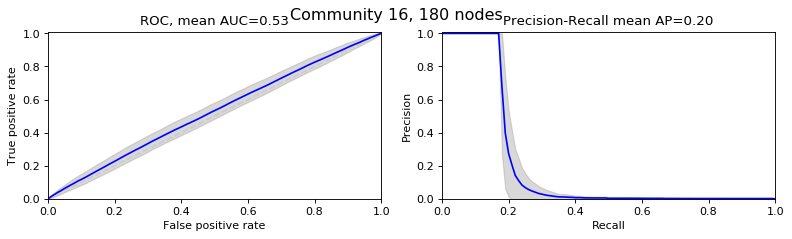

In [13]:
from scipy import interp
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score

seed_size = 3
samples = 200

auc_scores = dict()
app_scores = dict()

for c in sorted(comms.keys()):

    if len(comms[c]) <= seed_size:
        continue
    
    plt.figure(c)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_dpi(80)
    fig.set_size_inches(10, 3)
    fig.suptitle("Community {}, {} nodes".format(c, len(comms[c])), fontsize="x-large")
    
    auc_scores[c] = []
    app_scores[c] = []
    
   
    axes[0].set_xlabel("False positive rate")
    axes[0].set_ylabel("True positive rate")

    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.01])
    
    
    axes[1].set_ylabel("Precision")
    axes[1].set_xlabel("Recall")
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.01])
    
    axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
    
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    presc = []
    base_pr = np.linspace(0, 1, 101)
    
    for cs in unique_sampler(comms[c], seed_size, max_samples=samples):
        vec, key = mu_ivector(graph, index, cs)

        inc = lambda x: 1 if x in comms[c] else 0
        y_true = [inc(x) for x in graph.nodes() if x not in cs]
        y_score = [vec[key[x]] for x in graph.nodes() if x not in cs]
        
        
        auc_scores[c].append(roc_auc_score(y_true, y_score))
        app_scores[c].append(average_precision_score(y_true, y_score))
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr) 

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        
        tpr = interp(base_pr, precision, recall)
        tpr[0] = 1.0
        presc.append(tpr) 
           
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[0].plot(base_fpr, mean_tprs, 'b')
    axes[0].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    tprs = np.array(presc)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[1].plot(base_pr, mean_tprs, 'b')
    axes[1].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    axes[0].set_title('ROC, mean AUC={:.2f}'.format(np.mean(auc_scores[c])))
    
    axes[1].set_title('Precision-Recall mean AP={:.2f}'.format(np.mean(app_scores[c])))
    
    plt.tight_layout()

    

## Testing against random selection
No surprises here - in general selecting nodes at random from the network makes a poor classification system

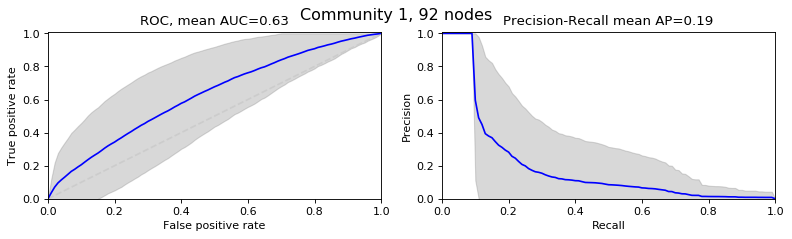

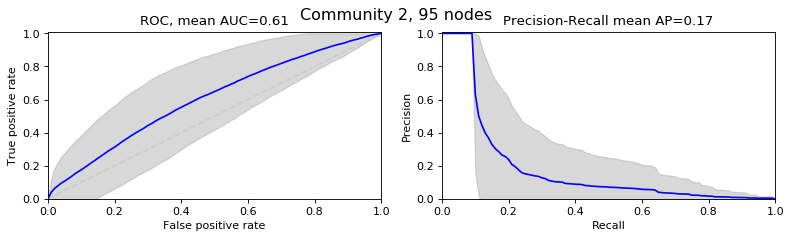

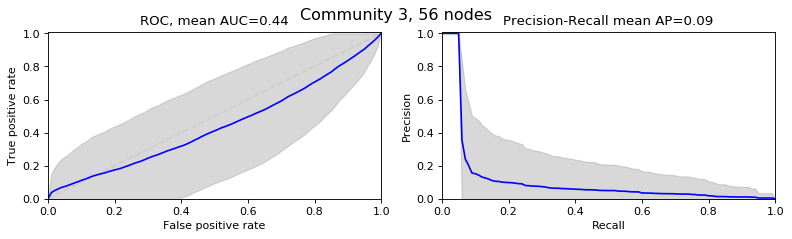

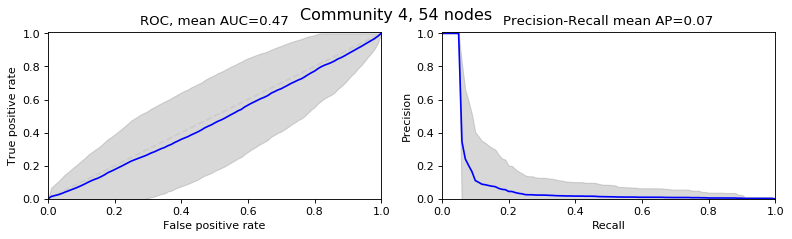

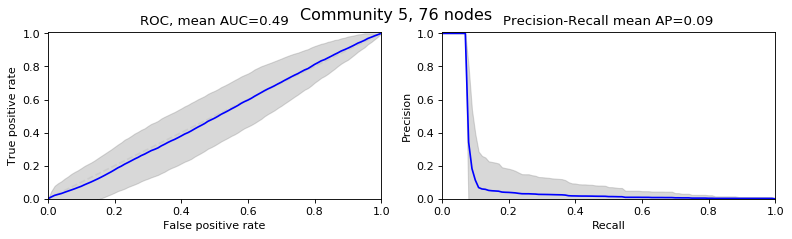

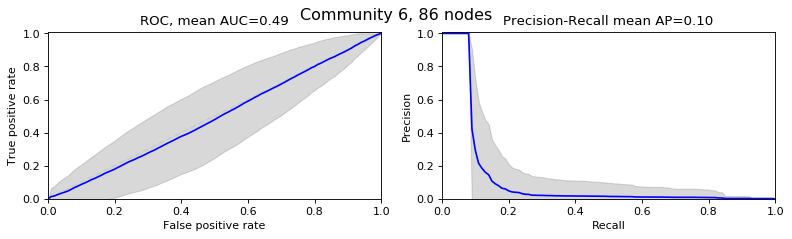

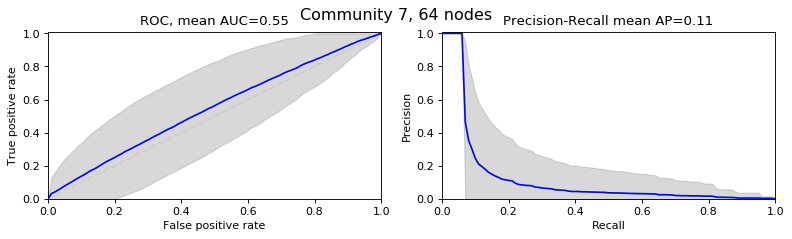

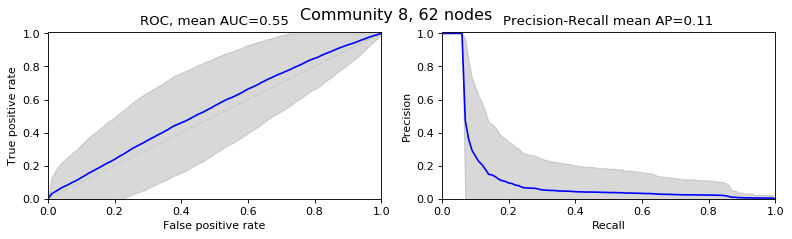

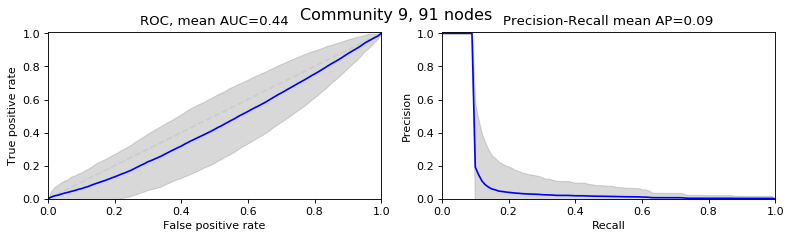

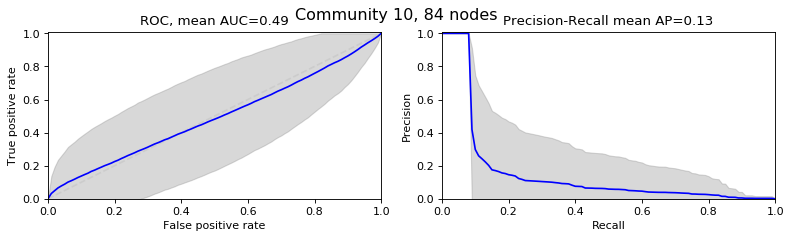

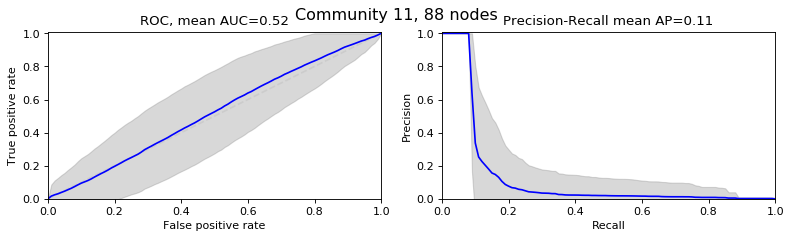

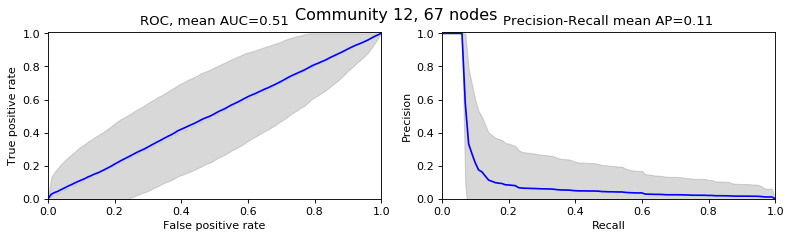

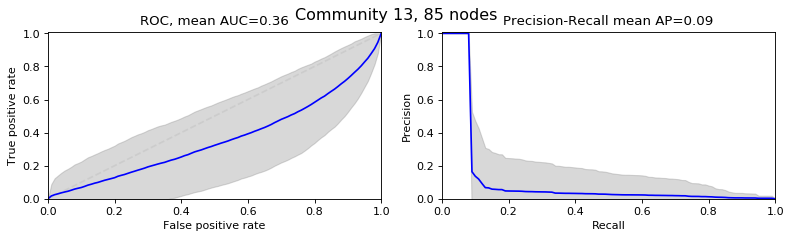

In [29]:
from scipy import interp
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score

seed_size = 3
samples = 50

auc_scores = dict()
app_scores = dict()

for c in sorted(comms.keys()):

    if len(comms[c]) <= seed_size:
        continue
    
    plt.figure(c)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_dpi(80)
    fig.set_size_inches(10, 3)
    fig.suptitle("Community {}, {} nodes".format(c, len(comms[c])), fontsize="x-large")
    
    auc_scores[c] = []
    app_scores[c] = []
    
   
    axes[0].set_xlabel("False positive rate")
    axes[0].set_ylabel("True positive rate")

    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.01])
    
    
    axes[1].set_ylabel("Precision")
    axes[1].set_xlabel("Recall")
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.01])
    
    axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
    
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    presc = []
    base_pr = np.linspace(0, 1, 101)
    
    for cs in unique_sampler(graph.nodes(), seed_size, max_samples=samples):
        vec, key = mu_ivector(graph, index, cs)

        inc = lambda x: 1 if x in comms[c] else 0
        y_true = [inc(x) for x in graph.nodes() if x not in cs]
        y_score = [vec[key[x]] for x in graph.nodes() if x not in cs]
        
        
        auc_scores[c].append(roc_auc_score(y_true, y_score))
        app_scores[c].append(average_precision_score(y_true, y_score))
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr) 

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        
        tpr = interp(base_pr, precision, recall)
        tpr[0] = 1.0
        presc.append(tpr) 
           
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[0].plot(base_fpr, mean_tprs, 'b')
    axes[0].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    tprs = np.array(presc)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[1].plot(base_pr, mean_tprs, 'b')
    axes[1].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    axes[0].set_title('ROC, mean AUC={:.2f}'.format(np.mean(auc_scores[c])))
    
    axes[1].set_title('Precision-Recall mean AP={:.2f}'.format(np.mean(app_scores[c])))
    
    plt.tight_layout()

    

# Distribution of $\mu_i$ Scores

Plotting the distribution of some of the query scores is interesting. Almost all the scores for vertices in the set cluster at lowe levels. So the nodes in the cluster are statistical outliers.


When I've plotted this with clearer divisions between clusters this has essentially been a bimodal distribution.

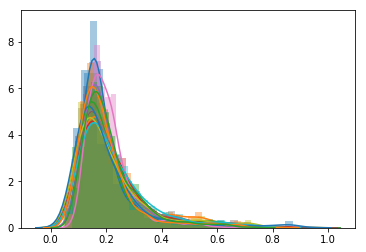

In [31]:
import seaborn
seed_size = 30
for c in comms:
    cs = np.random.choice(comms[c], seed_size, replace=False)

    # vec is the classifier distribution
    vec, key = mu_ivector(graph, index, cs)

    seaborn.distplot(vec, bins=30, norm_hist=True)

In [185]:
import pandas as pd
df = pd.DataFrame()
df.append?

# Experiments on cigram
Is it just that the LFR benchmark is too easy?

Lets try it on CiGRAM with a high degree of overlap and 60% of the edges between communities.

In [25]:
import cigram
n= 1000
avg_k=20
k=15
ek_per=0.6
p_o=0.5
seed=1337
graph, pos, comms = cigram.cigram_graph(n, avg_k, k, ek_per=ek_per, p_o=p_o, seed=seed)

graph.name = "cigram_{}-{}-{}-{}-{}-{}".format(n, avg_k, k, ek_per, p_o, seed)

print(graph.name)
index = indexer.get_index(graph)

cigram_1000-20-15-0.6-0.5-1337


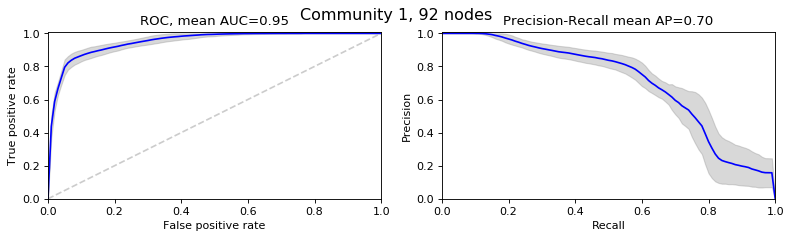

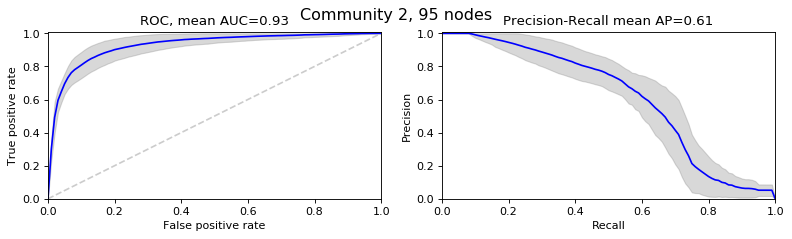

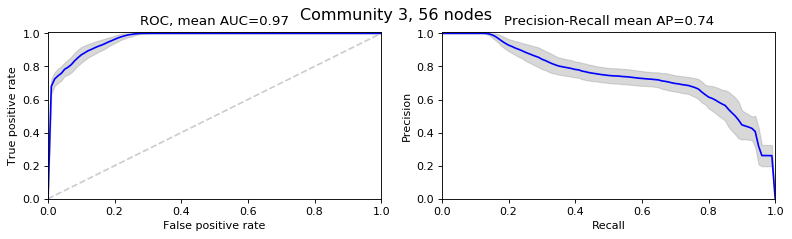

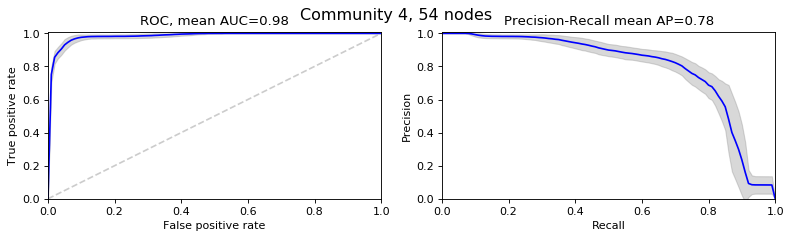

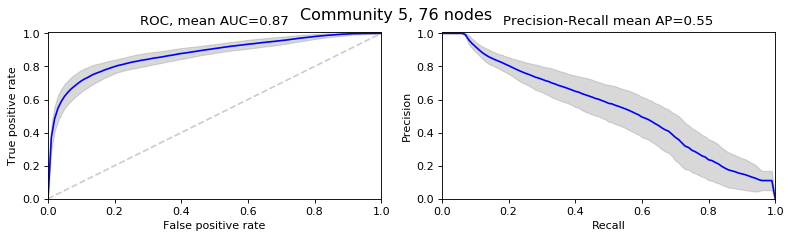

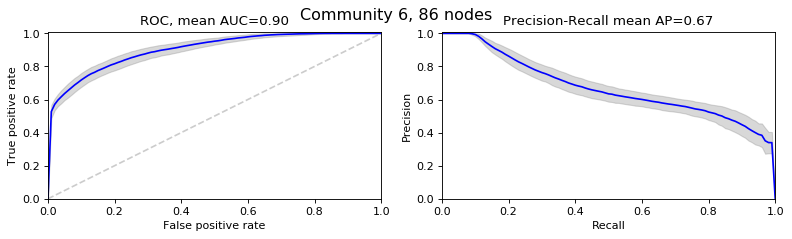

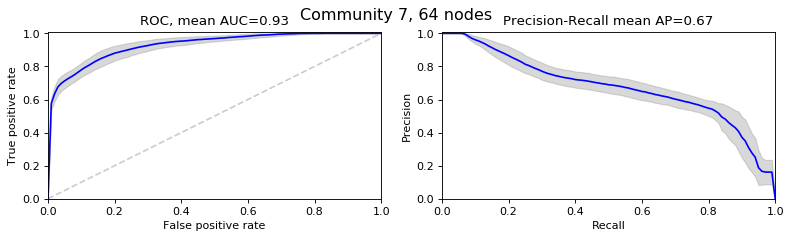

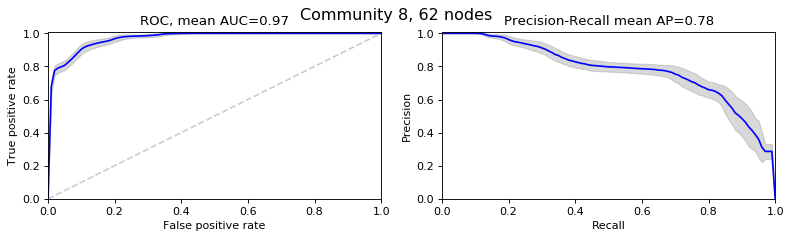

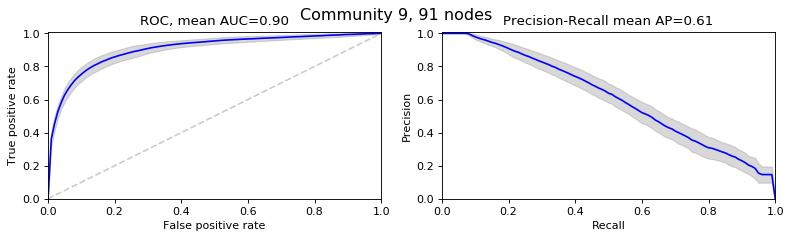

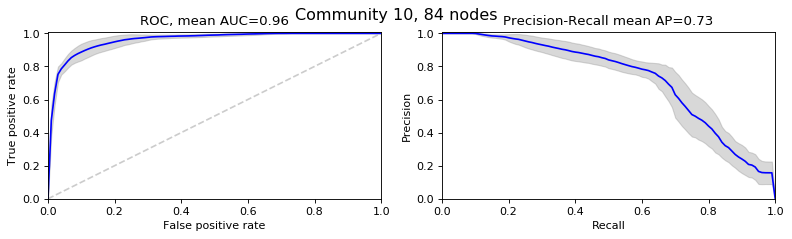

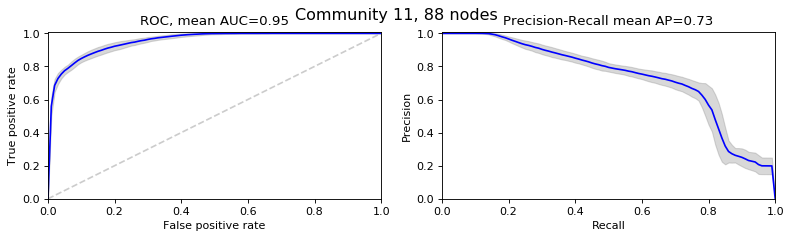

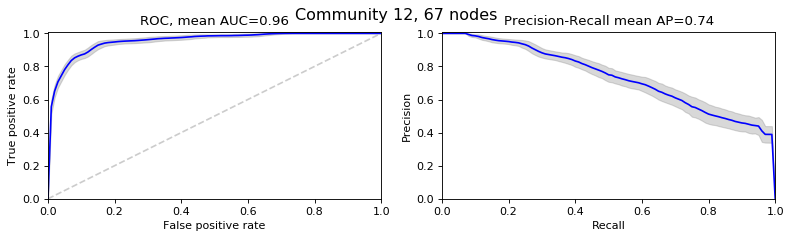

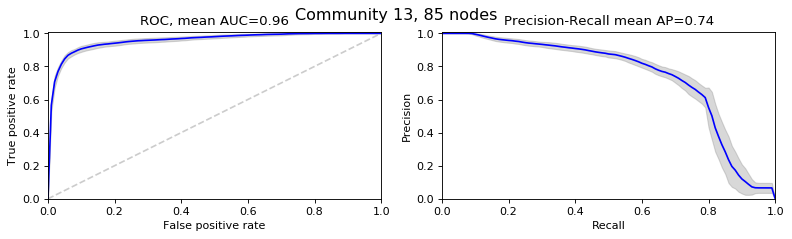

In [30]:
from scipy import interp
import scikitplot as skplt
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score

seed_size = 15
samples = 200

auc_scores = dict()
app_scores = dict()

for c in sorted(comms.keys()):

    if len(comms[c]) <= seed_size:
        continue
    
    plt.figure(c)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_dpi(80)
    fig.set_size_inches(10, 3)
    fig.suptitle("Community {}, {} nodes".format(c, len(comms[c])), fontsize="x-large")
    
    auc_scores[c] = []
    app_scores[c] = []
    
   
    axes[0].set_xlabel("False positive rate")
    axes[0].set_ylabel("True positive rate")

    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.01])
    
    
    axes[1].set_ylabel("Precision")
    axes[1].set_xlabel("Recall")
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.01])
    
    axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
    
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    presc = []
    base_pr = np.linspace(0, 1, 101)
    
    for cs in unique_sampler(comms[c], seed_size, max_samples=samples):
        vec, key = mu_ivector(graph, index, cs)

        inc = lambda x: 1 if x in comms[c] else 0
        y_true = [inc(x) for x in graph.nodes() if x not in cs]
        y_score = [vec[key[x]] for x in graph.nodes() if x not in cs]
        
        
        auc_scores[c].append(roc_auc_score(y_true, y_score))
        app_scores[c].append(average_precision_score(y_true, y_score))
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr) 

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        
        tpr = interp(base_pr, precision, recall)
        tpr[0] = 1.0
        presc.append(tpr) 
           
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[0].plot(base_fpr, mean_tprs, 'b')
    axes[0].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    tprs = np.array(presc)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    axes[1].plot(base_pr, mean_tprs, 'b')
    axes[1].fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    
    
    axes[0].set_title('ROC, mean AUC={:.2f}'.format(np.mean(auc_scores[c])))
    
    axes[1].set_title('Precision-Recall mean AP={:.2f}'.format(np.mean(app_scores[c])))
    
    plt.tight_layout()

    

Clearly this is worth spending some more time on!

In [128]:
import networkx as nx
import numpy as np
from sklearn.preprocessing import normalize


def diffusion_kernel(graph, query_nodes, beta=0.1):

    assert isinstance(graph, nx.Graph)

    l = np.array(nx.laplacian_matrix(graph).todense())
    diff_k = np.exp(-beta * l)

    score = np.zeros(graph.number_of_nodes())
    for i in query_nodes:
        score += diff_k[i]
    return score


def rwr(graph, query_nodes, restart_prob, _dthreshold=10e-7):

    a = nx.to_numpy_array(graph)
    
    nr = a.sum(axis=1)
    w = a / nr
    p_o = np.zeros(graph.number_of_nodes())
    
    np.put(p_o, query_nodes, 1.0/len(query_nodes))
    delta = 1.0
    p_t = np.copy(p_o)
    
    while delta > _dthreshold:
        no_restart = (1 - restart_prob) * np.squeeze(np.dot(w, p_t))
        restart = p_o * restart_prob
        p_tp1 = np.add(restart, no_restart)
        
        p_tp1 = ((1 - restart_prob) * np.dot(w, p_t)) + (restart_prob * p_o)
        delta = np.linalg.norm(p_t - p_tp1, 1)
        p_t = p_tp1
        
    return p_t


In [131]:
ve = rwr(graph, [0], 0.1)

for com in comms.values():
    # CV

defaultdict(list,
            {1: [12,
              18,
              33,
              43,
              132,
              162,
              171,
              180,
              188,
              190,
              191,
              220,
              222,
              251,
              263,
              264,
              266,
              326,
              359,
              360,
              377,
              382,
              391,
              431,
              443,
              444,
              475,
              494,
              508,
              533,
              545,
              580,
              606,
              619,
              620,
              628,
              644,
              665,
              670,
              708,
              720,
              744,
              763,
              774,
              806,
              812,
              814,
              829,
              870,
              897,
              901,
              

In [45]:
dk = diffusion_kernel(graph, [0,3], beta=0.2)

dk[0], np.mean(dk)

(1.4493289641172216, 2.0006698799935156)

In [7]:
np.exp()

2.718281828459045

array([[0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])